In [1]:
import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from scipy import optimize

from sklearn.preprocessing import PolynomialFeatures

import csv

import time

# 1 Univariate Logistic Regression

In [2]:
dataFile_1 = 'ex2data1.txt'

# 1.1 Data Visualisation

In [3]:
dF_1 = pd.read_csv(dataFile_1, header = None, names = ['x1', 'x2', 'y'])
sampleSize_1, nVariables_1 = dF_1.shape
print(dF_1.head())
print ("sampleSize =", sampleSize_1, "nVariables =", nVariables_1)

          x1         x2  y
0  34.623660  78.024693  0
1  30.286711  43.894998  0
2  35.847409  72.902198  0
3  60.182599  86.308552  1
4  79.032736  75.344376  1
sampleSize = 100 nVariables = 3


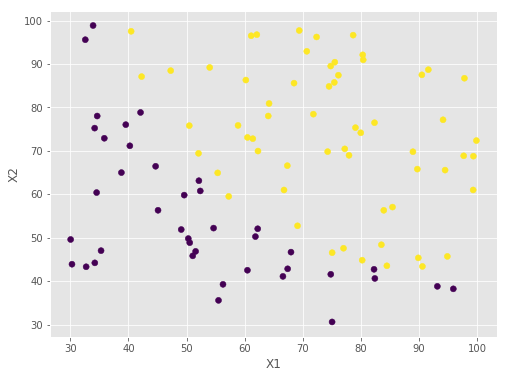

In [4]:
x1 = dF_1['x1']
x2 = dF_1['x2']
plt.figure(figsize=(8,6))
plt.scatter(x1, x2, c = dF_1['y'])
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

## 1.2 Data Extraction and Transformation

In [5]:
def getData(dataFile):
#     try wiht matrices as well
    data = np.loadtxt(dataFile, delimiter = ',')
    sampleSize, nVariables = data.shape
    X = np.insert(data[:, :-1], 0, 1, axis=1)
    y = data[:, -1:]
#     beta = np.matrix(np.zeros(nVariables)).T
    beta = np.zeros(nVariables)
    return beta, X.flatten(), y.flatten(), sampleSize, nVariables

## 1.3 Logistic Regression
### 1.3.1 Logistic Regression

**Sigmoid Function** ${\sigma}(z) = \frac{1}{1 + e^{-z}}$


### 1.3.2 Vectorisation of Logistic Regression

**Hypothesis** $h_{\beta}(X) =   \frac{1}{1 + e^{X\cdot\beta}}$

**Cost Function** $J = \frac{-1}{n}\sum(y^T\cdot \log h_{\beta} +(1-y)^T\cdot \log (1-h_{\beta}))$

In [6]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def hypothesis(beta, X, sampleSize, nVariables):
    beta = beta.reshape(nVariables, -1)
    X = X.reshape(sampleSize, -1)
    return sigmoid(np.dot(X, beta))

# def costFunction(X, y, beta):
def costFunction(beta, X, y, sampleSize, nVariables, iLambda=0.):
#     beta = beta.reshape(nVariables, -1)
#     X = X.reshape(sampleSize, -1)
    y = y.reshape(sampleSize, -1)
#     hypothesis vector h(n, 1)
    h = hypothesis(beta, X, sampleSize, nVariables)
#     cost scalar J(1, 1)
    J = (- np.dot(y.T, np.log(h)) - np.dot((1-y).T, np.log(1-h)))/sampleSize
#     similarly cost J can be calculated using np.multiply together with np.sum
#     cost = -np.sum(np.multiply(y, np.log(h)) + np.multiply((1-y), np.log(1-h)))/sampleSize
#     regularisation scalar (R)
    R = iLambda*np.dot(beta[1:].T,beta[1:])/(2*sampleSize)
    return (J + R)[0][0]

def betaOptimisation_1 (beta, X, y, sampleSize, nVariables, iLambda=0.):
    return optimize.fmin(costFunction, x0=beta, args=(X, y, sampleSize, nVariables, iLambda), maxiter=1500, full_output=True)

def prediction(beta, X, sampleSize, nVariables):
    return hypothesis(beta, X, sampleSize, nVariables) >= 0.5

## 1.4 Function Tests

In [7]:
betaTest_1, X_1, y_1, sampleSize_1, nVariables_1 = getData(dataFile_1)
y_1.shape

(100,)

### 1.4.1 Cost-Function Test
The outputs of the costFunction should be as follows:<br\>
betaTest (set to zeros), X, iLambda=0. — **J = 0.693** (Andrew Ng) <br\>

In [8]:
print("J =", costFunction(betaTest_1, X_1, y_1, sampleSize_1, nVariables_1))

J = 0.69314718056


### 1.5.1 Prediction Test
The outputs of the costFunction should be as follows:<br\>
Exam_1: 45, Exam_2: 85 — **P = 0.776** (Andrew Ng) <br\>

In [9]:
betaOpt_1 = betaOptimisation_1(betaTest_1, X_1, y_1, sampleSize_1, nVariables_1)[0]
xTest_1 = np.array([1, 45, 85])
sampleSizeTest_1 = 1
print("P =", hypothesis(betaOpt_1, xTest_1, sampleSizeTest_1, nVariables_1)[0][0])

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287
P = 0.776291590411


## 1.5 Results Visualisation & Analysis
### 1.5.1 Goodness of Fit Measures
#### 1.5.1.1 Decision Boundary
This comment is here thanks to this dude (https://github.com/vsevolodloik).<br />
Decision boundary is defined as follows:<br />
$\frac{1}{1 + e^{X\cdot\beta}} = \frac{1}{2}$<br />
Therefore, for the simple case of two variables, the equation of decision boundary takes the following form:<br />
$\beta_0+\beta_1\cdot{X_1}+\beta_2 \cdot{X_2} = 0$
#### 1.5.1.2 Types of Errors & Accuracy, Precision, Recal

The rate **type I error** (false positives) is denoted by $\alpha$.<br />
The rate **type II error** (false negatives) is denoted by $\beta$.<br /><br />
**Accuracy** $= \frac {tP + tN}{tP + tN + fP + fN}$<br /><br />
**Precision** $= \frac {tP}{tP + fP}$<br /><br />
**Recall** $= \frac {tP}{tP + fN}$

In [10]:
def goodnessOfFit(beta, X, y,  sampleSize, nVariables):
    beta_R = beta.reshape(nVariables, -1)
    X_R = X.reshape(sampleSize, -1)
    y_R = y.reshape(sampleSize, -1)
    p = prediction(beta, X, sampleSize, nVariables).flatten()
    
#     Elegant way to calculate tP, fP, and fN
    tP = np.sum(y*p)
    fP = np.sum(y-p==-1)
    fN = np.sum(y-p==1)
    accuracy = (X.shape[0] - fP - fN)/X.shape[0]
    precision  = tP/(tP+fP)
    recall  = tP/(tP+fN)
    print("Accuracy", accuracy, "\nPrecision =", precision, "\nRecall =", recall)
    
    plt.figure(figsize=(8,6))
    x1 = X_R[:, 1:2]
    x2 = X_R[:, 2:]
    plt.scatter(x1, x2, c = y_R[:, 0:])
    x2Fit = - beta_R[0]/beta_R[2] - x1*beta_R[1]/beta_R[2]
    plt.plot(x1, x2Fit, '-')
    plt.xlabel("X1")
    plt.ylabel("X2")
    return plt.show()

Accuracy 0.963333333333 
Precision = 0.901639344262 
Recall = 0.916666666667


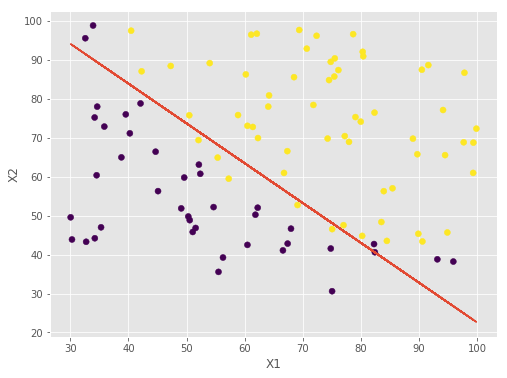

In [11]:
goodnessOfFit(betaOpt_1, X_1, y_1, sampleSize_1, nVariables_1)

http://www.johnwittenauer.net/tag/machine-learning/

http://aimotion.blogspot.se/2011/11/machine-learning-with-python-logistic.html

https://beckernick.github.io/logistic-regression-from-scratch/

https://github.com/kaleko/CourseraML/blob/master/ex2/ex2.ipynb

http://www.scipy-lectures.org/advanced/mathematical_optimization/

# 2 Multivariate Logistic Regression

In [12]:
dataFile_2 = 'ex2data2.txt'
dF_2 = pd.read_csv(dataFile_2, header = None)
sampleSize, nVariables = dF_2.shape
print ("sampleSize =", sampleSize, "nVariables =", nVariables)
print (dF_2.head())

sampleSize = 118 nVariables = 3
          0        1  2
0  0.051267  0.69956  1
1 -0.092742  0.68494  1
2 -0.213710  0.69225  1
3 -0.375000  0.50219  1
4 -0.513250  0.46564  1


## 2.1 Data Visualisation

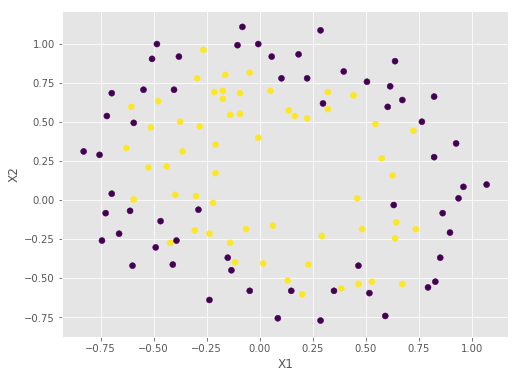

In [13]:
X_1s = dF_2.iloc[:, :1]
X_2s = dF_2.iloc[:, 1:2]
plt.figure(figsize=(8,6))
plt.scatter(X_1s, X_2s, c = dF_2.iloc[:, 2:])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## 2.2 Data Extraction Transformation
Add **polynomial** and **interaction** features using **SciKitLearn Preprocessing**<br\>
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [14]:
def addPolynomial(dataFile, polynomialDegree):
    data = np.loadtxt(dataFile, delimiter = ',')
    sampleSize, nVariables = data.shape
    X = data[:, :-1]
    y = data[:, -1:]
    poly = PolynomialFeatures(polynomialDegree)
#     X without intercept is passed to PolynomialFeatures.fit_transform.
#     Intercept is added automatically.
    polyX = poly.fit_transform(X)
    sampleSize, nVariables = polyX.shape
    beta = np.zeros((nVariables,1))
    return beta.flatten(), polyX.flatten(), y.flatten(), sampleSize, nVariables

## 2.3 Function Tests

In [15]:
betaPoly6, XPoly6, yPoly6, sampleSizePoly6, nVariablesPoly6 = addPolynomial(dataFile_2, 6)

### 2.3.1 Cost-Function Test
The outputs of the costFunction should be as follows:<br\>
betaTest (set to zeros), X, iLambda=0. — **J = 0.693** (Andrew Ng) <br\>

In [16]:
print("J =",costFunction(betaPoly6, XPoly6, yPoly6, sampleSizePoly6, nVariablesPoly6))

J = 0.69314718056


In [17]:
def betaOptimisation_2(beta, X, y, sampleSize, nVariables, iLambda=0.):
#     Number of iterations significantly affects the output of this function
    optimisedBeta = optimize.minimize(costFunction, beta, args=(X, y, sampleSize, nVariables, iLambda),
                                      method='BFGS', options={'maxiter':200, "disp":False})

#     optimisedBeta = optimize.fmin_cg(costFunction, fprime=backPropagation, x0=flatBeta,
#                                      args=(layer, flatX, sampleSize, y, yUnique),
#                                      maxiter=50,disp=True,full_output=True)
    return(optimisedBeta['x'])

In [18]:
# betaOpt = betaOptimisation(betaPoly6, XPoly6, yPoly6, iLambda = 0.)[0]

## 2.4 Results Visualisation & Analysis

In [19]:
def decisionBoundary(beta, X, y, sampleSize, nVariables, xMin, xMax, step, polyOrder, iLambda=0.):
    p = prediction(beta, X, sampleSize, nVariables).flatten()
    tP = np.sum(y*p)
    fP = np.sum(y-p==-1)
    fN = np.sum(y-p==1)
    precision  = tP/(tP+fP)
    recall  = tP/(tP+fN)
    accuracy = (X.shape[0] - fP - fN)/X.shape[0]
    print("Accuracy", accuracy, "\nPrecision =", precision, "\nRecall =", recall)
    
    xx = np.linspace(xMin[0], xMax[0], step)
    yy = np.linspace(xMin[1], xMax[1], step)
    XX, YY = np.meshgrid(xx, yy)
    XY = np.concatenate((XX.reshape(step**2, -1), YY.reshape(step**2, -1)), axis=1)
#     X without intercept is passed to PolynomialFeatures.fit_transform.
#     Intercept is added automatically.
    poly = PolynomialFeatures(polyOrder)
    polyXY = poly.fit_transform(XY)
    ZZ = hypothesis(beta, polyXY, step**2, polyXY.shape[1]).reshape(step, -1)
#     ZZ = prediction(beta, polyXY, step**2, polyXY.shape[1]).reshape(step, -1)
#     For plt.contour, ZZ is a matrix
#     xx(XX) and yy(YY) can be either matrices or vectors of appropriate dimensions
    decisionBoundary = plt.contour(xx, yy, ZZ, [0.5])
    plt.clabel(decisionBoundary, inline=1, fontsize=15, fmt = '$\lambda $= %d'%iLambda)

    x_1 = X.reshape(sampleSize,-1)[:, 1:2]
    x_2 = X.reshape(sampleSize,-1)[:, 2:3]
    plt.scatter(x_1, x_2, c = y.reshape(sampleSize,-1)[:, 0:])
    plt.title("Decision Boundary")
    plt.xlabel("X1")
    plt.ylabel("X2")
    return plt.show()

Accuracy 0.995157384988 
Precision = 0.828125 
Recall = 0.913793103448


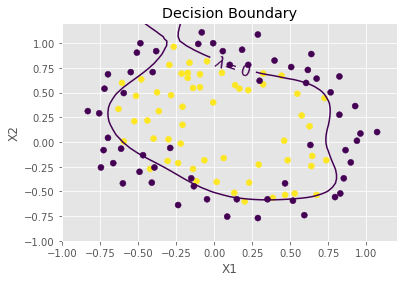

In [20]:
iLambda = 0
polyOrder = 6
betaPoly, XPoly, yPoly, sS_Poly, nV_Poly = addPolynomial(dataFile_2, polyOrder)
betaOpt_2 = betaOptimisation_2(betaPoly, XPoly, yPoly, sS_Poly, nV_Poly, iLambda)

xMin = (-1., -1.)
xMax = (1.2, 1.2)
step = 50
decisionBoundary(betaOpt_2, XPoly, yPoly, sS_Poly, nV_Poly, xMin, xMax, step, polyOrder, iLambda)

Accuracy 0.995157384988 
Precision = 0.828125 
Recall = 0.913793103448


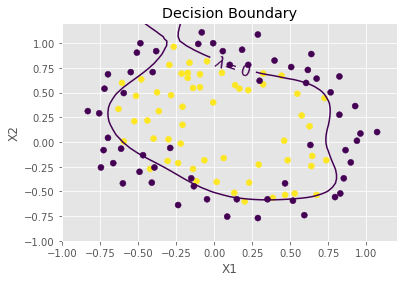

Accuracy 0.993946731235 
Precision = 0.779411764706 
Recall = 0.913793103448


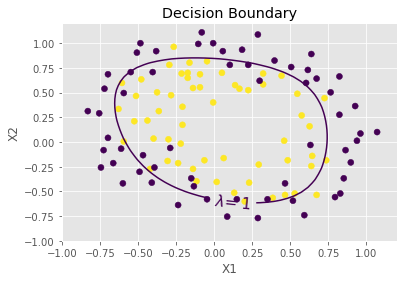

Accuracy 0.990920096852 
Precision = 0.694444444444 
Recall = 0.862068965517


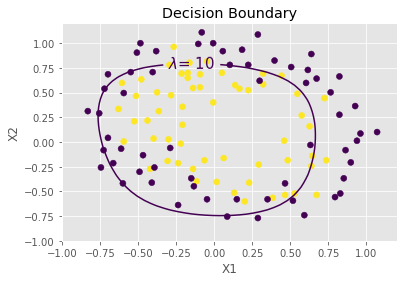

Accuracy 0.98607748184 
Precision = 0.642857142857 
Recall = 0.465517241379


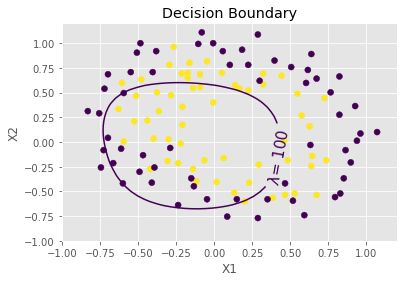

In [21]:
for i, iLambda in enumerate([0., 1., 10, 100 ]):
    polyOrder = 6
    betaPoly, XPoly, yPoly, sampleSizePoly, nVariablesPoly = addPolynomial(dataFile_2, polyOrder)
    betaOpt = betaOptimisation_2(betaPoly, XPoly, yPoly, sampleSizePoly, nVariablesPoly, iLambda)
    xMin = (-1., -1.)
    xMax = (1.2, 1.2)
    step = 50
    decisionBoundary(betaOpt, XPoly, yPoly, sampleSizePoly, nVariablesPoly, xMin, xMax, step, polyOrder, iLambda)